# House prices

Kairos (April 2018)

## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

# Intro to Neural Networks

* Define a neural network (NN) and its hidden layers using the TensorFlow DNNRegressor class
* Train a neural network to learn nonlinearities in a dataset and achieve better performance than a linear regression model

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [83]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


## 2. Load our data set
Next, we'll load our data set and show information about it.

In [84]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1447,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1448,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1449,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


In [85]:
# Create a synthetic feature.
# Create a new category for total habitable surface
housing_dataframe["habitableSF"] = housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"] + housing_dataframe["GrLivArea"]
#housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] / row['habitableSF'], axis=1)
housing_dataframe['SQMeter_price'] = 0  

In [86]:
def preprocess_features(housing_dataframe):
  """Prepares input features from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = housing_dataframe[
    ["MSZoning",
     "YearRemodAdd",
     "Utilities",
     "Neighborhood",
     "HouseStyle",
     "BedroomAbvGr",
     "OverallCond"]]
  processed_features = selected_features.copy()
  
 
  # Create a new synthetic feature
  processed_features['SQMeter_price'] = ( 
    housing_dataframe['SalePrice'] / 
    housing_dataframe['habitableSF'])

  return processed_features

def preprocess_targets(housing_dataframe):
  """Prepares target features (i.e., labels) from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["SalePrice"] = (
    housing_dataframe["SalePrice"])
  return output_targets

## 3. Splitting

In [87]:
# Choose the first 1000 (out of 1451) examples for training.
training_examples = preprocess_features(housing_dataframe.head(1000))
training_targets = preprocess_targets(housing_dataframe.head(1000))

# Choose the last 500 (out of 1451) examples for validation.
validation_examples = preprocess_features(housing_dataframe.tail(500))
validation_targets = preprocess_targets(housing_dataframe.tail(500))

# Double-check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,SQMeter_price
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,0.4,1985.1,0.0,9.5,1.1,2.9,5.6,60.8
std,0.8,20.4,0.0,5.8,1.3,0.8,1.1,15.5
min,0.0,1950.0,0.0,0.0,0.0,0.0,1.0,15.2
25%,0.0,1967.0,0.0,5.0,0.0,2.0,5.0,50.7
50%,0.0,1994.0,0.0,10.0,1.0,3.0,5.0,60.2
75%,0.0,2004.0,0.0,13.0,1.0,3.0,6.0,69.3
max,4.0,2010.0,1.0,24.0,7.0,8.0,9.0,138.1


Validation examples summary:


,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,SQMeter_price
count,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,0.3,1983.8,0.0,9.3,1.2,2.9,5.6,59.3
std,0.8,21.2,0.0,6.0,1.3,0.8,1.1,15.7
min,0.0,1950.0,0.0,0.0,0.0,0.0,3.0,14.2
25%,0.0,1964.8,0.0,5.0,0.0,2.0,5.0,49.0
50%,0.0,1992.0,0.0,9.0,1.0,3.0,5.0,59.2
75%,0.0,2004.0,0.0,14.0,1.0,3.0,6.0,68.9
max,4.0,2010.0,0.0,24.0,7.0,6.0,9.0,118.8


Training targets summary:


,SalePrice
count,1000.0
mean,181962.4
std,80430.9
min,34900.0
25%,130000.0
50%,162950.0
75%,215000.0
max,755000.0


Validation targets summary:


,SalePrice
count,500.0
mean,176991.2
std,76270.3
min,37900.0
25%,128975.0
50%,160000.0
75%,203000.0
max,745000.0


# 4. Building a Neural Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [88]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [89]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [90]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print "Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error
  print "Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error

  return dnn_regressor

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 185000 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


NOTE: This selection of parameters is somewhat arbitrary. Here we've tried combinations that are increasingly complex, combined with training for longer, until the error falls below our objective. This may not be the best combination; others may attain an even lower RMSE. If your aim is to find the model that can attain the best error, then you'll want to use a more rigorous process, like a parameter search.

Training model...
RMSE (on training data):
  period 00 : 178577.76
  period 01 : 98006.16
  period 02 : 79381.82
  period 03 : 79326.79
  period 04 : 79264.66
  period 05 : 79336.55
  period 06 : 79409.10
  period 07 : 79260.64
  period 08 : 79115.03
  period 09 : 79055.93
Model training finished.
Final RMSE (on training data):   79055.93
Final RMSE (on validation data): 75264.16


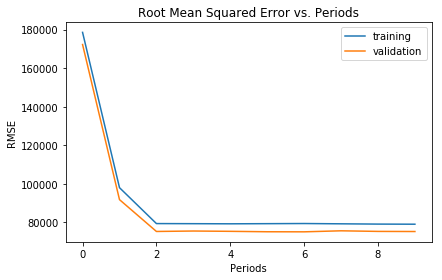

In [99]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.003,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 2: Evaluate on Test Data

**Confirm that your validation performance results hold up on test data.**

Once you have a model you're happy with, evaluate it on test data to compare that to validation performance.

Reminder, the test data set is located "input/cleaned_houses_prices_test.csv").

Similar to what the code at the top does, we just need to load the appropriate data file, preprocess it and call predict and mean_squared_error.

Note that we don't have to randomize the test data, since we will use all records.

In [105]:
housing_test_data = pd.read_csv("input/cleaned_houses_prices_test.csv", sep=",")

# Create a synthetic feature.
# Create a new category for total habitable surface
housing_test_data["habitableSF"] = housing_test_data["1stFlrSF"] + housing_test_data["2ndFlrSF"] + housing_test_data["GrLivArea"]
housing_test_data['SQMeter_price'] = 0  

test_examples = preprocess_features(housing_test_data)
test_targets = preprocess_targets(housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["SalePrice"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print "Final RMSE (on test data): %0.2f" % root_mean_squared_error

    

Final RMSE (on test data): 78040.84
Accuracy Tensor("Mean:0", shape=(), dtype=float32)


# 5. Creating predictions on test set

In [102]:


# Write predictions to csv file
# We don't have any significative field so we save the index
results = pd.DataFrame({'Index': test_examples.index, 'Prediction': test_predictions, 'Price': test_targets['SalePrice']})
results
# Save to file
# This file will be visible after publishing in the output section
#results.to_csv('results.csv', index=False)
#results.head()

,Index,Prediction,Price
0,0,186082.5,208500
1,1,184085.1,181500
2,2,186060.0,223500
3,3,182177.7,140000
4,4,185622.0,250000
...,...,...,...
1446,1446,185357.4,175000
1447,1447,184221.3,210000
1448,1448,186208.0,266500
1449,1449,185568.0,142125
